In [12]:
!pip install rasterio

In [13]:
!pip install scikit-learn

In [14]:
!pip install scikit-image

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import rasterio as rio

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

from PIL import Image



In [16]:
images_dir ='../data/images'
masks_dir = '../data/masks'
metrics_dir='../metrics'
models_dir='../models'

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [17]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

In [18]:
# Application of color maps
def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask

In [19]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}


In [20]:
from collections import namedtuple
Label = namedtuple('Label', ['name','id','color'])
labels = [
    Label('Building',  1, (60,  16,  152)),
    Label('Land',  2, (132, 41, 246)),
    Label('Road',  3, (110, 193, 228)),
    Label('Vegetation',  4,  (254, 221, 58)),
    Label('Water',  5,    (226, 169, 41)),
    Label('Object',  6, (155, 155, 155)),
   ]

In [21]:
color2label = {label.color: label for label in labels}
print(color2label)

{(60, 16, 152): Label(name='Building', id=1, color=(60, 16, 152)), (132, 41, 246): Label(name='Land', id=2, color=(132, 41, 246)), (110, 193, 228): Label(name='Road', id=3, color=(110, 193, 228)), (254, 221, 58): Label(name='Vegetation', id=4, color=(254, 221, 58)), (226, 169, 41): Label(name='Water', id=5, color=(226, 169, 41)), (155, 155, 155): Label(name='Object', id=6, color=(155, 155, 155))}


In [22]:
def RGBtoOneHot(rgb, color_mapping_dict): # Renamed colorDict to color_mapping_dict for clarity
    """
    Converts an RGB label mask to a 2D single-channel label mask.
    `rgb`: HxWx3 numpy array (can be float [0,1] or int [0,255])
    `color_mapping_dict`: Dictionary mapping RGB tuples to integer class IDs.
    """
    arr = np.zeros(rgb.shape[:2], dtype=np.uint8) # Initialize as a 2D array (HxW)

    # Convert rgb values to 0-255 range if they are floats (plt.imread can return float)
    if rgb.dtype == np.float32 or rgb.dtype == np.float64:
        rgb_int = (rgb * 255).astype(np.uint8)
    else:
        rgb_int = rgb

    # Ensure rgb_int has 3 channels for comparison
    if rgb_int.shape[-1] != 3:
        raise ValueError(f"Input RGB image to RGBtoOneHot must have 3 channels, but got shape {rgb.shape}")

    # Iterate through the actual color map for IDs
    for color_tuple, class_id in color_mapping_dict.items():
        # Create a boolean mask for pixels matching the current color
        matches = np.all(rgb_int == np.array(color_tuple), axis=-1)
        arr[matches] = class_id # Assign the actual class ID

    return arr

In [23]:

train_accuracy=[]
train_f1=[]
train_precision=[]
train_recall=[]
train_mse=[]


#full_img = data.skin()
for i in range(len(train_images)):
    print(f"Processing image {i+1}/{len(train_images)}")
    image_path=os.path.join(images_dir, train_images[i])
    full_img=plt.imread(image_path)
    full_img=full_img[:900, :900]
    mask_data = os.path.join(masks_dir, train_masks[i])
    mask_data=plt.imread(mask_data)
    mask_data=mask_data[:900, :900]

    mask_labels=RGBtoOneHot(mask_data, color_map) # Use color_map here

    # Check if mask_labels contains any non-zero values
    if not np.any(mask_labels > 0):
        print(f"Skipping image {train_images[i]} as its mask contains no labeled segments.")
        continue

    #print(mask_labels)
    #print(mask_labels.shape)


    # Build an array of labels for training the segmentation. NOTE: This section was previously commented out.
    # For the `future.fit_segmenter` to work, it expects the `labels` argument to contain
    # actual ground truth labels for the areas to be classified.
    # If this is intended to be used for training, you'll need a way to generate these labels,
    # but for now, we'll continue using `mask_labels` as the primary ground truth.
    # The error 'Found array with 0 sample(s)' implies mask_labels was all zeros,
    # which we're now handling by skipping.
    training_labels = mask_labels.copy() # Use the generated mask_labels as training_labels


    sigma_min = 1
    sigma_max = 16
    features_func = partial(
        feature.multiscale_basic_features,
        intensity=True,
        edges=False,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1,
    )
    features = features_func(full_img)
    #print(features.shape)
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
    #print(mask_labels.shape)
    #print(features.shape)
    #print(training_labels.shape)

    clf = future.fit_segmenter(mask_labels, features, clf)
    predicted_labels = future.predict_segmenter(features, clf)
    predicted_labels_2d = predicted_labels.reshape(full_img.shape[:2]).astype(np.uint8)

    # Convert the 2D predicted labels to a colored RGB image for display
    colored_predicted_result = apply_color_map(predicted_labels_2d, color_map)

    # Add metrics
    train_mse.append(np.mean((predicted_labels.flatten() - mask_labels.flatten())**2))
    train_accuracy.append(accuracy_score(mask_labels.flatten(), predicted_labels.flatten()))
    train_f1.append(f1_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))
    train_precision.append(precision_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))
    train_recall.append(recall_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))

Processing image 1/162
Processing image 2/162
Processing image 3/162
Processing image 4/162
Processing image 5/162
Processing image 6/162
Processing image 7/162
Processing image 8/162
Processing image 9/162
Processing image 10/162
Processing image 11/162
Processing image 12/162
Processing image 13/162
Processing image 14/162
Processing image 15/162
Processing image 16/162
Processing image 17/162
Processing image 18/162
Processing image 19/162
Processing image 20/162
Processing image 21/162
Processing image 22/162
Processing image 23/162
Processing image 24/162
Processing image 25/162
Processing image 26/162
Processing image 27/162
Processing image 28/162
Processing image 29/162
Processing image 30/162
Processing image 31/162
Processing image 32/162
Processing image 33/162
Processing image 34/162
Processing image 35/162
Processing image 36/162
Processing image 37/162
Processing image 38/162
Processing image 39/162
Processing image 40/162
Processing image 41/162
Processing image 42/162
P

Random Forest Classifier

In [24]:
val_accuracy=[]
val_f1=[]
val_precision=[]
val_recall=[]
val_mse=[]



#full_img = data.skin()
for i in range(len(val_images)):
    print(f"Processing image {i+1}/{len(val_images)}")
    image_path=os.path.join(images_dir, val_images[i])
    full_img=plt.imread(image_path)
    full_img=full_img[:900, :900]
    mask_data = os.path.join(masks_dir, val_masks[i])
    mask_data=plt.imread(mask_data)
    mask_data=mask_data[:900, :900]
    #print(full_img.shape)
    #print(mask_data.shape)
    mask_labels=RGBtoOneHot(mask_data, color_map) # Use color_map here

    # Check if mask_labels contains any non-zero values
    if not np.any(mask_labels > 0):
        print(f"Skipping image {train_images[i]} as its mask contains no labeled segments.")
        continue

    #print(mask_labels)
    #print(mask_labels.shape)


    # Build an array of labels for training the segmentation. NOTE: This section was previously commented out.
    # For the `future.fit_segmenter` to work, it expects the `labels` argument to contain
    # actual ground truth labels for the areas to be classified.
    # If this is intended to be used for training, you'll need a way to generate these labels,
    # but for now, we'll continue using `mask_labels` as the primary ground truth.
    # The error 'Found array with 0 sample(s)' implies mask_labels was all zeros,
    # which we're now handling by skipping.
    validation_labels = mask_labels.copy() # Use the generated mask_labels as training_labels


    sigma_min = 1
    sigma_max = 16
    features_func = partial(
        feature.multiscale_basic_features,
        intensity=True,
        edges=False,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1,
    )
    features = features_func(full_img)
    #print(features.shape)
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
    #print(mask_labels.shape)
    #print(features.shape)
    #print(training_labels.shape)

    clf = future.fit_segmenter(mask_labels, features, clf)
    predicted_labels = future.predict_segmenter(features, clf)
    predicted_labels_2d = predicted_labels.reshape(full_img.shape[:2]).astype(np.uint8)

    # Convert the 2D predicted labels to a colored RGB image for display
    colored_predicted_result = apply_color_map(predicted_labels_2d, color_map)

    # Add metrics
    val_mse.append(np.mean((predicted_labels.flatten() - mask_labels.flatten())**2))
    val_accuracy.append(accuracy_score(mask_labels.flatten(), predicted_labels.flatten()))
    val_f1.append(f1_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))
    val_precision.append(precision_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))
    val_recall.append(recall_score(mask_labels.flatten(), predicted_labels.flatten(), average='weighted'))


Processing image 1/41
Processing image 2/41
Processing image 3/41
Processing image 4/41
Processing image 5/41
Processing image 6/41
Processing image 7/41
Processing image 8/41
Processing image 9/41
Processing image 10/41
Processing image 11/41
Processing image 12/41
Processing image 13/41
Processing image 14/41
Processing image 15/41
Processing image 16/41
Processing image 17/41
Processing image 18/41
Processing image 19/41
Processing image 20/41
Processing image 21/41
Processing image 22/41
Processing image 23/41
Processing image 24/41
Processing image 25/41
Processing image 26/41
Processing image 27/41
Processing image 28/41
Processing image 29/41
Processing image 30/41
Processing image 31/41
Processing image 32/41
Processing image 33/41
Processing image 34/41
Processing image 35/41
Processing image 36/41
Processing image 37/41
Processing image 38/41
Processing image 39/41
Processing image 40/41
Processing image 41/41


In [49]:
#save model
import pickle
with open(os.path.join(models_dir, 'RandomForestClassifier_model.pkl'), 'wb') as file:
    pickle.dump(RandomForestClassifier, file)

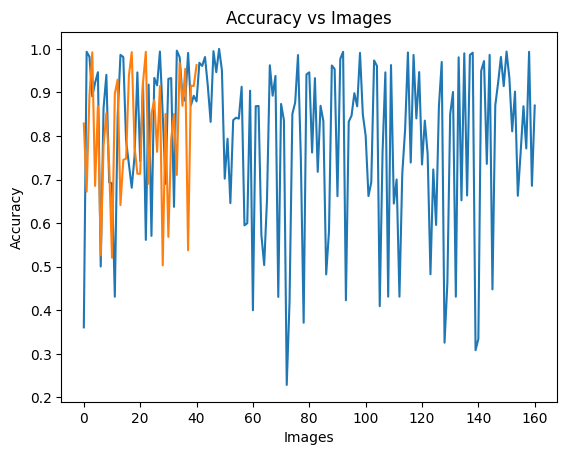

In [25]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy vs Images')
plt.xlabel('Images')
plt.ylabel('Accuracy')
#plt.savefig(os.path.join(metrics_dir, 'kmeans_accuracy.png'))
plt.show()

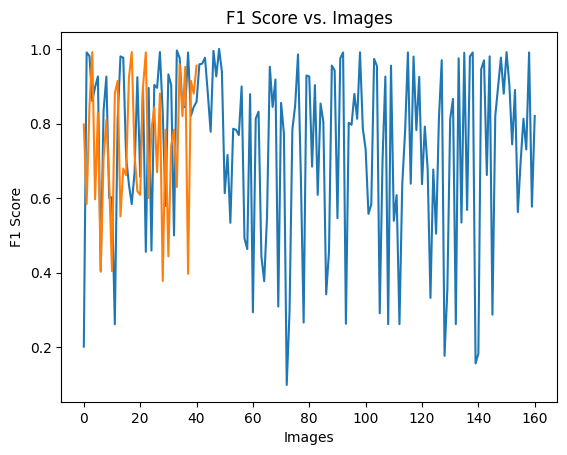

In [26]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 Score vs. Images')
plt.xlabel('Images')
plt.ylabel('F1 Score')
#plt.savefig(os.path.join(metrics_dir, 'kmeans_f1.png'))
plt.show()

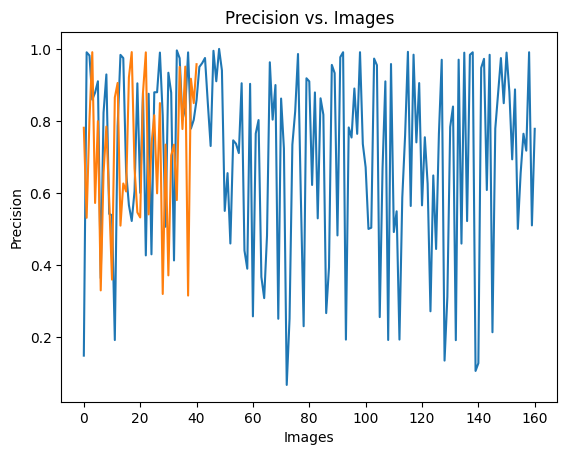

In [27]:
plt.plot(train_precision)
plt.plot(val_precision)
plt.title('Precision vs. Images')
plt.xlabel('Images')
plt.ylabel('Precision')
#plt.savefig(os.path.join(metrics_dir, 'kmeans_f1.png'))
plt.show()

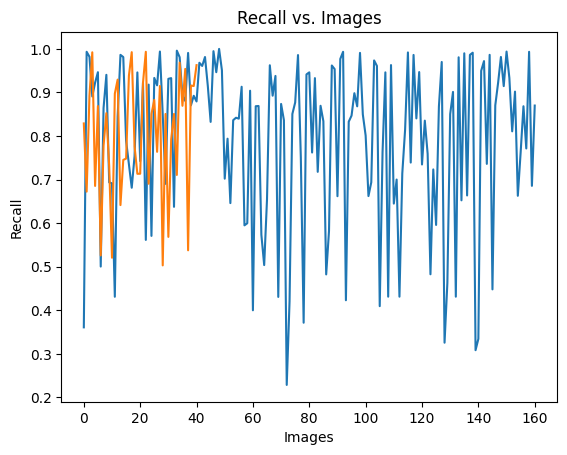

In [28]:
plt.plot(train_recall)
plt.plot(val_recall)
plt.title('Recall vs. Images')
plt.xlabel('Images')
plt.ylabel('Recall')
#plt.savefig(os.path.join(metrics_dir, 'kmeans_f1.png'))
plt.show()

In [45]:
val_f1_score=np.max(val_f1)
print(f"Best F1 Score: {val_f1_score:.2f}")

Best F1 Score: 0.99


In [46]:
train_f1_score=np.max(train_f1)
print(f"Best F1 Score: {train_f1_score:.2f}")

Best F1 Score: 1.00


In [41]:
train_accuracy_score=np.max(train_accuracy)
print(f"Best Accuracy Score: {train_accuracy_score:.2f}")

Best Accuracy Score: 1.00


In [42]:
val_accuracy_score=np.max(val_accuracy)
print(f"Best Accuracy Score: {val_accuracy_score:.2f}")

Best Accuracy Score: 0.99


In [43]:
train_mse_score=np.max(train_mse)
print(f"Best Accuracy Score: {train_mse_score:.2f}")

Best Accuracy Score: 5.87


In [44]:
val_mse_score=np.max(val_mse)
print(f"Best Accuracy Score: {val_mse_score:.2f}")

Best Accuracy Score: 3.23


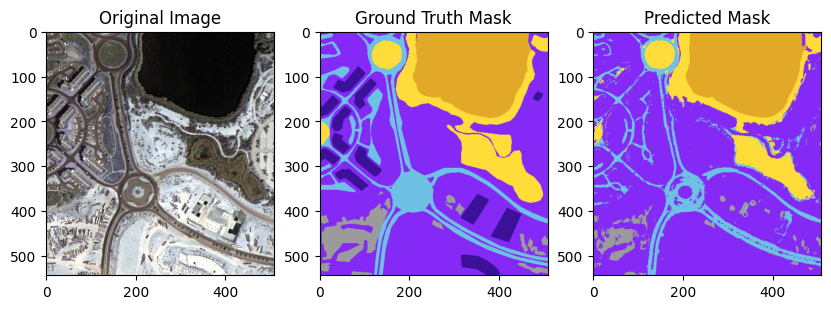

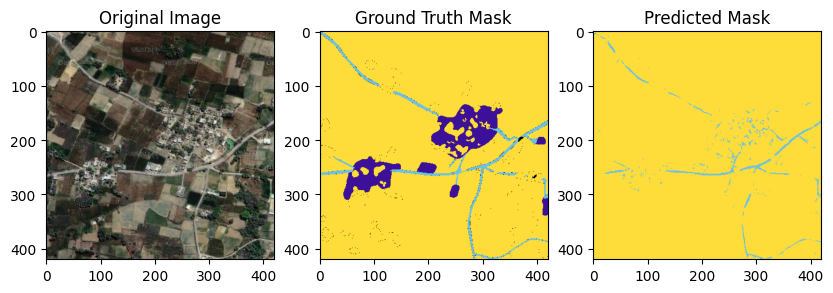

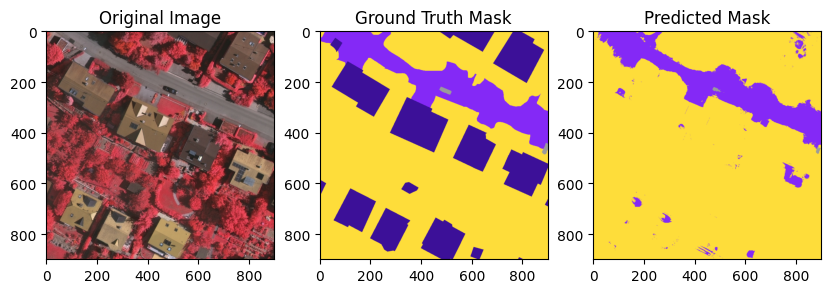

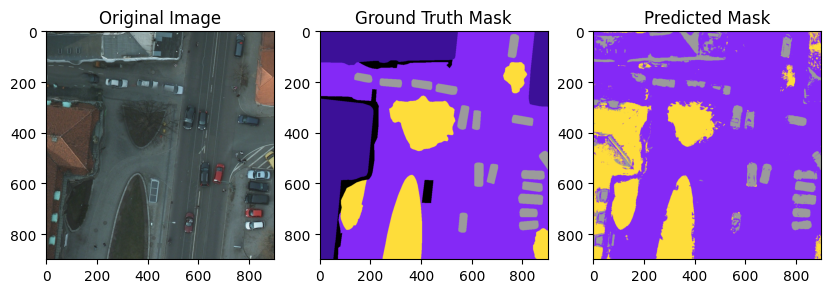

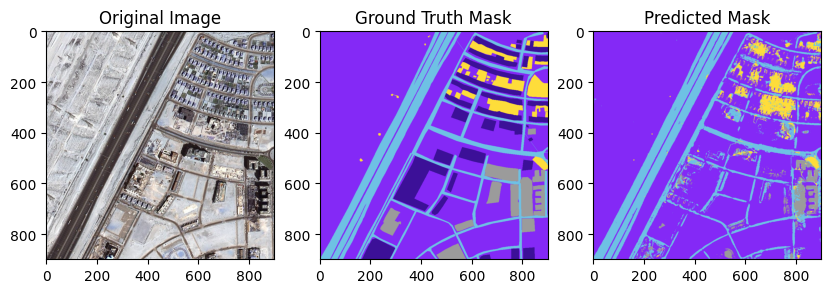

In [34]:
for i in np.arange(0, 5):
    idx=np.random.randint(0, len(val_images))
    image_data=plt.imread(os.path.join(images_dir, val_images[idx]))
    mask_data=plt.imread(os.path.join(masks_dir, val_masks[idx]))
    mask_data=mask_data[:900, :900]
    image_data=image_data[:900, :900]
    mask_labels=RGBtoOneHot(mask_data, color_map)

    features = features_func(image_data)
    clf = future.fit_segmenter(mask_labels, features, clf)
    predicted_labels = future.predict_segmenter(features, clf)
    predicted_labels_2d=predicted_labels.reshape(image_data.shape[0], image_data.shape[1])
     # Convert the 2D predicted labels to a colored RGB image for display
    colored_predicted_result = apply_color_map(predicted_labels_2d, color_map)


    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(image_data)
    axes[0].set_title('Original Image')
    axes[1].imshow(mask_data)
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(colored_predicted_result)
    axes[2].set_title('Predicted Mask')

In [47]:
metrics_df={'f1':[train_f1_score, val_f1_score], 'accuracy':[train_accuracy_score, val_accuracy_score], 'mse':[train_mse_score, val_mse_score]}
metrics_df=pd.DataFrame(metrics_df, index=['training', 'validation'])
metrics_df

,f1,accuracy,mse
training,1.000000,1.000000,5.872325
validation,0.991748,0.993413,3.233793


In [48]:
metrics_df.to_csv(os.path.join(metrics_dir, 'randomforest_metrics.csv'))